## Newspaper Topic Modeling
Let's use this space to topic mine some of the headlines from the American Stories dataset from Harvard. First, let's get some basic libraries and packages installed for the analysis.

In [2]:
!pip install bertopic
!pip install fsspec
!pip install datasets
!pip install joypy
!pip install pandas

done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached xxhash-3.5.0-cp39-cp39-macosx_10_9_x86_64.whl (31 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached aiohappyeyeballs-2.4.3-py3-none-any.whl (14 kB)
  Using cached yarl-1.18.0-cp39-cp39-macosx_10_9_x86_64.whl (94 kB)
  Using cached propcache-0.2.0-cp39-cp39-macosx_10_9_x86_64.whl (46 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl (6.2 kB)
  Using cached frozenlist-1.5.0-cp39-cp39-macosx_10_9_x86_64.whl (54 kB)
  Using cached multidict-6.1.0-cp39-cp39-macosx_10_9_x86_64.whl (29 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/bin/python /opt/anaconda3/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /var/folders/cd/7nn45pbd15n_

In [ ]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from os import walk
from bertopic import BERTopic
from datasets import load_dataset
import random
import joypy
import math
from matplotlib import cm

## Data Ingestion + Exploration
We're ingesting the dataset from Hugging Face, which makes it easy to read public data from their database using the load_dataset function. The size of the dataset is absolutely massive, and so I'm choosing a subset of data from the range of years between 1800 and 1970 for every 10 years.

In [ ]:
%%time
subsets = [str(x) for x in range(1800, 1970, 10)]
dataset = load_dataset("dell-research-harvard/AmericanStories",
                       "subset_years",
                       year_list = subsets,
                       trust_remote_code = True)

CPU times: user 1.22 s, sys: 2.46 s, total: 3.68 s
Wall time: 56.9 s


In [ ]:
def yearly_word_counts(ds):
  output = pd.DataFrame()
  for year in [key for key in ds.keys() if key != "word_count"]: # exclude the word count attribute
    print(f"Number of articles in {year}: {len(ds[year]['article'])}")
    word_counts = [len(x.split()) for x in ds[year]['article']] # store the distribution as a list of values per year
    # convert the list to a pandas series
    word_counts_series = pd.Series(word_counts)
    # append to the DataFrame
    output[year] = word_counts_series

  output = output.stack().reset_index()
  output = output[["level_1", 0]]
  output.columns = ["year", "word_count"]
  output["log_word_count"] = [math.log(x) for x in output["word_count"]]
  return output
word_counts = yearly_word_counts(dataset)

Number of articles in 1800: 45
Number of articles in 1810: 982
Number of articles in 1820: 433
Number of articles in 1830: 4232
Number of articles in 1840: 8052
Number of articles in 1850: 49992
Number of articles in 1860: 150590
Number of articles in 1870: 174061
Number of articles in 1880: 272352
Number of articles in 1890: 540615
Number of articles in 1900: 1118970
Number of articles in 1910: 1684263
Number of articles in 1920: 2041192
Number of articles in 1930: 492695
Number of articles in 1940: 496662
Number of articles in 1950: 415416
Number of articles in 1960: 344550


In [ ]:
word_counts

,level_0,level_1,0
0,0,1800,72
1,0,1810,193
2,0,1820,147
3,0,1830,172
4,0,1840,175
...,...,...,...
760,44,1920,88
761,44,1930,87
762,44,1940,41
763,44,1950,145


In [ ]:
word_counts = word_counts[["level_1", 0]]
word_counts.columns = ["year", "word_count"]
word_counts["log_word_count"] = [math.log(x) for x in word_counts["word_count"]]
word_counts

,year,word_count,log_word_count
0,1800,72,4.276666
1,1810,193,5.262690
2,1820,147,4.990433
3,1830,172,5.147494
4,1840,175,5.164786
...,...,...,...
760,1920,88,4.477337
761,1930,87,4.465908
762,1940,41,3.713572
763,1950,145,4.976734


I thought a cool analysis would be the progression of article length through the years. My informal hypothesis was that article length would steadily decrease as the years progressed. This would be in-line with today's trend of shorter articles, but I realized that the scope of my dataset doesn't allow for a more current analysis after the creation of the internet. From what I can see, article length is pretty consistent through much of the 19th and 20th centuries.

I also notice that, since a single year contains multiple sources, there's going to be a lot of variation in terms of word count. One year can have an article stretch from 15 words to 2000 words. To account for this range, I do a log transformation on the word counts to shorten the tails of the distributions.

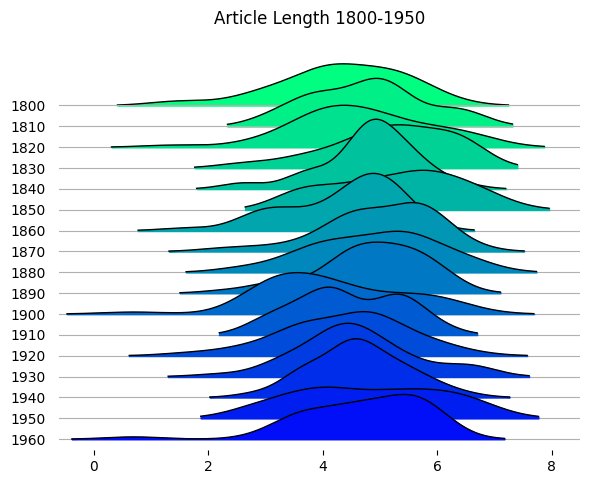

In [ ]:
fig, axes = joypy.joyplot(word_counts, by="year", column="log_word_count", range_style='own',
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Article Length 1800-1950",
                          background = "w",
                          colormap=cm.winter_r)

It's not realistic to train a model on all of my article data since the corpus is so large. Instead, I'll sample ~1000 rows from every year to create a representative subsample of the population on which a smaller training set can be built.

One thing I don't do is stratify my subsample. The Detroit News may only publish monthly whereas the Detroit Free Press publishes weekly. If I don't have similar proportions of both, then the training set will unwittingly undervalue those sources that publish on less of a frequent basis. This is definitely a point of future improvement.

In [ ]:
def subsample_hf_dataset(ds, n):
  # Sample n observations per year
  print(type(dataset))
  sampled_data = []
  subsets = [str(x) for x in ds.keys()]
  for year in subsets:
      yearly_data = ds[year]
      # Sample n observations (or all if less than n)
      sample_size = min(n, len(yearly_data))
      print(f"sample size of year {year}: {sample_size}")
      sampled_yearly_data = yearly_data.shuffle(seed=42).select(range(sample_size))
      sampled_data.append(sampled_yearly_data)

  # Concatenate all sampled yearly data into one dataset
  sampled_dataset = pd.concat([d.to_pandas() for d in sampled_data], ignore_index=True)

  # Convert to pandas DataFrame if needed
  return sampled_dataset

In [ ]:
sampled_dataset = subsample_hf_dataset(dataset, 1000)

The original data is stored in individual JSON files on my host machine. The data needs to be read into a singular DataFrame so that I can do some analysis and preprocessing.

In [ ]:
sampled_dataset

,article_id,newspaper_name,edition,date,page,headline,byline,article
0,10_1800-04-07_p4_sn83016063_00332895059_180004...,Jenks's Portland gazette.,01,1800-04-07,p4,coMMMonwEALrH OF MASSACHUSETTS.\n\n\nIN SENATE...,,"IN SENATE, January IS, I 500.\nON the petition..."
1,15_1800-04-07_p4_sn83016063_00332895059_180004...,Jenks's Portland gazette.,01,1800-04-07,p4,"COMMONWEALTH OF MASSACHUSETTS,\n\n\nIn Senate....",,"IN 3en0ffs <Vo. !, 1000.\nON the Petition of t..."
2,49_1800-04-07_p4_sn83016063_00332895059_180004...,Jenks's Portland gazette.,01,1800-04-07,p4,,,"Scarborough. Feb. a., 1890."
3,53_1800-09-15_pNone_sn83016063_00332895059_180...,Jenks's Portland gazette.,01,1800-09-15,pNone,= = l-sl,,"Dl6D-Ar NovsIouceaer, MT. P-ylsy S-ry,ey-very"
4,4_1800-04-07_p4_sn83016063_00332895059_1800040...,Jenks's Portland gazette.,01,1800-04-07,p4,"TO BE SOLD,","On advantageous terms and Ja6ieiesf credit,","On Advantageous terms and JaG1cieT credit,\nA ..."
...,...,...,...,...,...,...,...,...
15455,18_1960-07-01_p4_sn87062224_00514156931_196007...,Milford chronicle.,01,1960-07-01,p4,CURIOSITY Is EXPENSIVE,,PENSACOLA. Fla. Up Call It\ncompassion. curios...
15456,105_1960-01-30_p17_sn83045462_00280608300_1960...,Evening star.,01,1960-01-30,p17,"VIRGINIA\nRaantifnl hrgrl, ro..Lio- Cpo ,",,"Beautiful brick rambler, SEQ Arl.\nblvd. tCovi..."
15457,8_1960-06-11_p12_sn83045462_00280608865_196006...,Evening star.,01,1960-06-11,p12,,,acquaintance of Mr.. Zanuck's; !;\nOrson Welle...
15458,44_1960-06-09_p78_sn83045462_00280608865_19600...,Evening star.,01,1960-06-09,p78,,,"FORD 81 Fordor; Fordomatic, T.\nand h., 2 new ..."


After ingesting a few scans worth of data, we're able to see a distribution that shows the range of article lengths. The distribution had a definite positive skew with a longer tail on its right side. This doesn't especially impact our analysis here, but it's worth noting that not all of these articles will be homogenous in length or content. I'd be interested in how the model performs on shorter articles (< 200 words) versus those that are a bit longer.

<Axes: xlabel='article_length', ylabel='Count'>

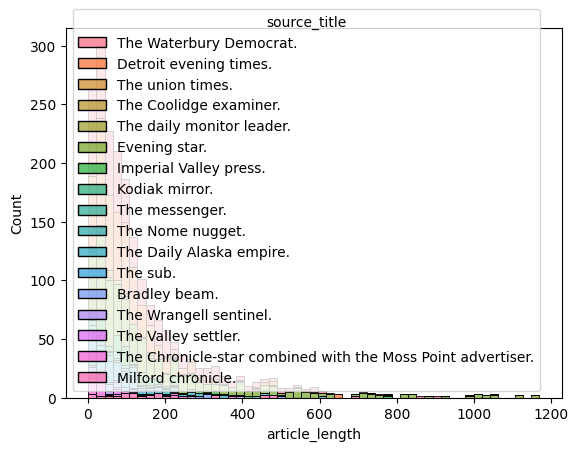

In [ ]:
sns.histplot(data=sampled_dataset,
             x='article_length',
             hue='source_title',
             multiple='stack')

I fit the model below and train it on the entire corpus of subsampled data from the original Hugging Face data. I considered training one model per decade and examining

In [ ]:
# Initialize and fit BERTopic model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(documents)
# Generate topics over time
topics_over_time = topic_model.topics_over_time(documents, timestamps)
# Visualize how topics evolve over time
topic_model.visualize_topics_over_time(topics_over_time)

In [ ]:
%%time
model = BERTopic(verbose=True,
                 embedding_model='paraphrase-MiniLM-L3-v2',
                 min_topic_size= 7)
article_topics, probabilities = model.fit_transform(sampled_dataset["article"])

2024-11-24 18:01:28,965 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/484 [00:00<?, ?it/s]

2024-11-24 18:08:22,387 - BERTopic - Embedding - Completed ✓
2024-11-24 18:08:22,390 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-24 18:09:04,054 - BERTopic - Dimensionality - Completed ✓
2024-11-24 18:09:04,056 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-24 18:09:04,984 - BERTopic - Cluster - Completed ✓
2024-11-24 18:09:04,995 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-24 18:09:10,062 - BERTopic - Representation - Completed ✓
2024-11-24 18:09:12,286 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 3976) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
298it [02:32,  1.95it/s]


KeyboardInterrupt: 

In [ ]:
%%time
topics_over_time = model.topics_over_time(sampled_dataset["article"],
                                          sampled_dataset["date"],
                                          nr_bins = 99)

26it [00:56,  2.18s/it]

CPU times: user 56.4 s, sys: 460 ms, total: 56.9 s
Wall time: 57 s


This is an incredibly interesting exercise. Let me use this space to let out some of my thoughts.

(1) I thought I would see a lot more topics related to war, considering how much of the 20th century was spent with the United States at war.

(2) The topic for "france_french_paris_germany" spiked in the 1940s, which may have something to do with the advent of World War II.

(3) Because of my choice in subset, I only select articles that are published every 10 years. This excludes many of the articles reporting from World Wars I and II, as well as the Cold War. It's likely that the war-related topics are in the subset I didn't select.

That said, the adaptive choice of which subset to consider would dramatically change my results. If I changed the subset range step size to 5, then we'd have coverage across many of the years currently missing from the analysis. Similarly, if I ran my data specifically on the decade from 1935 - 1945 then we would likely see more articles having to do with war and Europe.

In [ ]:
# Visualize how topics evolve over time
model.visualize_topics_over_time(topics_over_time)

In [ ]:
topics_over_time[topics_over_time.Topic == 104]

,Topic,Words,Frequency,Timestamp,Name
146,104,"maine, prof, 10, uih, combatants",2,1819-09-30 21:05:27.272727296,104_slavery_it_south_their
218,104,"slaves, condition, among, more, crimes",1,1829-06-27 19:38:10.909090944,104_slavery_it_south_their
308,104,"domestic, slavery, thoughts, concern, volume",1,1839-03-25 18:10:54.545454592,104_slavery_it_south_their
426,104,"acquiescence, satisfac, reconciliation, conces...",1,1848-12-20 16:43:38.181818112,104_slavery_it_south_their
497,104,"slavery, south, bruce, own, their",3,1850-08-05 16:29:05.454545408,104_slavery_it_south_their
557,104,"thems, elves, terrific, ries, determine",1,1858-09-17 15:16:21.818181888,104_slavery_it_south_their
643,104,"wrong, slavery, it, institution, mean",1,1860-05-02 15:01:49.090909184,104_slavery_it_south_their
1399,104,"labor, negroes, treated, actrocious, inexorably",1,1918-10-14 06:18:10.909090816,104_slavery_it_south_their
1710,104,"islands, kwangcho, indochisa, tahita, tonkin",1,1939-11-22 03:09:05.454545408,104_slavery_it_south_their
1920,104,"rhodesia, african, africa, racial, afri",3,1959-05-17 00:14:32.727272448,104_slavery_it_south_their


This particular matrix demonstrates the importance of considering temporal changes in language when topic modelling. The global tag assigned to this topic was "104_slavery_it_south_their", but the words associated with the topic can change as the decades go on.

Slavery, for example, has existed throughout American media by different names. In 1829, slaves were spoken about in terms of their living conditions and the enslaved were associated with crimes. Immeadiately prior to the Civil War, in 1860, we see slavery associated with the words "institution" and "wrong" which is the messaging used by the North to frame slavery as an awful instituion unique to the South.

With the advent of the Great Migration, we see more formerly enslaved Black Americans moving to the North of the country in search of jobs. This well-known phenomenon (known as the Great Migration) is shown in the representation of the slavery topic during 1918 when Black migrants are associated with the word "labor".

And we see the final tag of topic 104 in 1959. The tag is applied to articles discussing the decolonization of Africa when Europeans released their remaining colonies from bondage. The term "Rhodesia" makes an appearance, which was one of the last surviving British colonies on the continent. When the formerly-enslaved South Africans confronted British colonists, the Brits secluded themselves into their own country and declared unilateral independence from their former subjects. The United Nations later declared the settlement illegal and banned any nation from recognizing the state of colonizers.

In [ ]:
%%time
subsets = [str(x) for x in range(1935, 1945)]
dataset_1930 = load_dataset("dell-research-harvard/AmericanStories",
                       "subset_years",
                       year_list = subsets,
                       trust_remote_code = True)

Only taking a subset of years. Change name to 'all_years' to use all years in the dataset.
{'1930': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1930.tar.gz', '1931': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1931.tar.gz', '1932': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1932.tar.gz', '1933': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1933.tar.gz', '1934': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1934.tar.gz', '1935': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1935.tar.gz', '1936': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1936.tar.gz', '1937': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1937.tar.gz', '1938': 'https://hug

faro_1931.tar.gz:   0%|          | 0.00/383M [00:00<?, ?B/s]

faro_1932.tar.gz:   0%|          | 0.00/568M [00:00<?, ?B/s]

faro_1933.tar.gz:   0%|          | 0.00/567M [00:00<?, ?B/s]

faro_1934.tar.gz:   0%|          | 0.00/573M [00:00<?, ?B/s]

faro_1935.tar.gz:   0%|          | 0.00/540M [00:00<?, ?B/s]

faro_1936.tar.gz:   0%|          | 0.00/549M [00:00<?, ?B/s]

faro_1937.tar.gz:   0%|          | 0.00/557M [00:00<?, ?B/s]

faro_1938.tar.gz:   0%|          | 0.00/556M [00:00<?, ?B/s]

faro_1939.tar.gz:   0%|          | 0.00/470M [00:00<?, ?B/s]

faro_1941.tar.gz:   0%|          | 0.00/544M [00:00<?, ?B/s]

faro_1942.tar.gz:   0%|          | 0.00/459M [00:00<?, ?B/s]

faro_1943.tar.gz:   0%|          | 0.00/406M [00:00<?, ?B/s]

faro_1944.tar.gz:   0%|          | 0.00/400M [00:00<?, ?B/s]

faro_1945.tar.gz:   0%|          | 0.00/534M [00:00<?, ?B/s]

faro_1946.tar.gz:   0%|          | 0.00/481M [00:00<?, ?B/s]

faro_1947.tar.gz:   0%|          | 0.00/430M [00:00<?, ?B/s]

faro_1948.tar.gz:   0%|          | 0.00/414M [00:00<?, ?B/s]

faro_1949.tar.gz:   0%|          | 0.00/388M [00:00<?, ?B/s]

Generating 1930 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1931 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1932 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1933 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1934 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1935 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1936 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1937 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1938 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1939 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1940 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1941 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1942 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1943 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1944 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1945 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1946 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1947 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1948 split: 0 examples [00:00, ? examples/s]

Loading associated


Generating 1949 split: 0 examples [00:00, ? examples/s]

Loading associated
CPU times: user 30min 21s, sys: 1min 14s, total: 31min 35s
Wall time: 35min 53s


In the section above, I add more data from the time period 1930 - 1950. I believe this time to be deeply transformational for the United States, and so I decided to take a closer look when parsing through the dataset. As opposed to studying trends that occur once every ten years, as in the previous dataset, I'm interested in seeing continuous patterns of topic growth.

In [ ]:
%%time
word_counts_1930 = yearly_word_counts(dataset_1930)

Number of articles in 1930: 492695
Number of articles in 1931: 493816
Number of articles in 1932: 664615
Number of articles in 1933: 642380
Number of articles in 1934: 654342
Number of articles in 1935: 635554
Number of articles in 1936: 662015
Number of articles in 1937: 676549
Number of articles in 1938: 665274
Number of articles in 1939: 556283
Number of articles in 1940: 496662
Number of articles in 1941: 637200
Number of articles in 1942: 523923
Number of articles in 1943: 467200
Number of articles in 1944: 433769
Number of articles in 1945: 588477
Number of articles in 1946: 470895
Number of articles in 1947: 393086
Number of articles in 1948: 396660
Number of articles in 1949: 419854
CPU times: user 2min 41s, sys: 7.58 s, total: 2min 49s
Wall time: 3min 18s


In [ ]:
sampled_dataset_1930 = subsample_hf_dataset(dataset_1930, 1000)

<class 'datasets.dataset_dict.DatasetDict'>
sample size of year 1930: 1000
sample size of year 1931: 1000
sample size of year 1932: 1000
sample size of year 1933: 1000
sample size of year 1934: 1000
sample size of year 1935: 1000
sample size of year 1936: 1000
sample size of year 1937: 1000
sample size of year 1938: 1000
sample size of year 1939: 1000
sample size of year 1940: 1000
sample size of year 1941: 1000
sample size of year 1942: 1000
sample size of year 1943: 1000
sample size of year 1944: 1000
sample size of year 1945: 1000
sample size of year 1946: 1000
sample size of year 1947: 1000
sample size of year 1948: 1000
sample size of year 1949: 1000


In [ ]:
%%time
model = BERTopic(verbose=True,
                 embedding_model='paraphrase-MiniLM-L3-v2',
                 min_topic_size= 7)
article_topics, probabilities = model.fit_transform(sampled_dataset_1930["article"])

2024-11-24 19:46:35,615 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2024-11-24 19:54:48,669 - BERTopic - Embedding - Completed ✓
2024-11-24 19:54:48,672 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-24 19:55:07,844 - BERTopic - Dimensionality - Completed ✓
2024-11-24 19:55:07,847 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-24 19:55:17,298 - BERTopic - Cluster - Completed ✓
2024-11-24 19:55:17,315 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-24 19:55:20,934 - BERTopic - Representation - Completed ✓


CPU times: user 8min 49s, sys: 2.47 s, total: 8min 51s
Wall time: 8min 47s


In [ ]:
%%time
topics_over_time = model.topics_over_time(sampled_dataset_1930["article"],
                                          sampled_dataset_1930["date"],
                                          nr_bins = 20)

20it [01:08,  3.41s/it]

CPU times: user 1min 5s, sys: 887 ms, total: 1min 6s
Wall time: 1min 8s


I think this topic model is much more interesting. Since the C-TF-IDF is trained to consider temporal relationships between words, the timeframe matters much more than in previous models. A few examples are below.

(1) The newly-founded Soviet Union was formed in 1922. We'll see the terms "Russia" and "Soviet" used interchangably throughout the remaining 20 years of analysis, hence why they're tied under the same topic number.

(2) Polyester was also commercialized around this time, which gave rise to the term "rayon" in the 1920s. This demonstrates that Americans have struggled with the term "polyester" even from the beginning.

(3) Interestingly, topics referencing Hitler and Nazi Germany peaked pre-World War II, which began in 1944. I chose this timeframe specifically becuase I thought the trace of war-associated terms would spike, but this doesn't seem to be the case.

(4) Probably the most interesting trend is in relation to labor. Phrases associated with workers, strikes, and unionization spiked shortly after the end of World War II, in 1945.

In [ ]:
# Visualize how topics evolve over time
model.visualize_topics_over_time(topics_over_time)

NameError: name 'model' is not defined

In [ ]:
# get a list of sources from the time period
sampled_dataset_1930["newspaper_name"].unique()

array(['The Indianapolis times.', 'The Washington times.',
       'Nogales international.', 'New Britain herald.', 'Evening star.',
       'Milford chronicle.', 'The Daily Alaska empire.',
       'Seward daily gateway.', 'Imperial Valley press.',
       'The Nome nugget.', 'The Lexington advertiser.', 'Putnam patriot.',
       'Hyder weekly herald.', 'The Ely miner.',
       'The Sauk Centre herald.', 'The Carbon County news.',
       'Smyrna times.', 'The daily worker.', 'The Coolidge examiner.',
       'The Wrangell sentinel.', 'The Redwood gazette.', 'The Alaskan.',
       'The Kusko times.', 'The Alaska fisherman.', 'The Arizona gleam.',
       'Plentywood herald.', 'The border vidette.',
       'The Chapel Hill weekly.', 'The producers news.',
       'The Waterbury Democrat.', 'The Bismarck tribune.',
       'Western news and the Libby times.', 'Weekly herald.',
       'Red Lodge daily news combined with Carbon County news.',
       'Montana labor news.', 'Henderson daily dispatch

In [ ]:
keys = [key for key in dataset_1930.keys()]
sources = set()
for year in keys:
  focus = dataset_1930[year]
  # get the newspapers from that year
  yearly_sources = set(focus["newspaper_name"])
  # add it to the set one-by-one
  for source in yearly_sources:
    sources.add(source)
sources

{'Afro-American courier.',
 'Arizona sun.',
 'Arkansas State press.',
 'Arkansas survey-journal.',
 'Askov American.',
 'Automotive news.',
 'Bradley beam.',
 'Browning chief.',
 'Carbon County news.',
 'Carolina watchman.',
 'Chicago world.',
 'Connecticut chronicle.',
 'Detroit evening times.',
 'Eastern Connecticut news.',
 'Evening star.',
 'Glacier County chief.',
 'Greenbelt cooperator.',
 'Hartford chronicle.',
 'Hartford-Springfield chronicle.',
 'Henderson daily dispatch.',
 'Hungry Horse news and Columbian.',
 'Hungry Horse news.',
 'Hyder weekly herald.',
 'Imperial Valley press.',
 'Jackson advocate.',
 'Kodiak mirror.',
 'Laurel outlook.',
 'Marion progress.',
 'Matanuska Valley pioneer.',
 'Metropolitan news.',
 'Milford chronicle.',
 'Minneapolis spokesman.',
 'Montana farmer-stockman.',
 'Montana labor news.',
 'Montana oil and mining journal.',
 'Montgomery County sentinel.',
 'Moose Pass miner.',
 'New Britain herald.',
 'New England bulletin.',
 'Nogales internationa

In [ ]:
# interesting sources
interesting = [
    "The tribune independent of Michigan.",
    "The times-news.",
    "The guardian.",
    "The globe-independent.",
    "The daily worker.",
    "The Phoenix Jewish news.",
    "The Michigan chronicle.",
    "The Detroit tribune.",
    "Detroit evening times.",
    "Chicago world."
]

In [ ]:
# go back through and isolate those sources
interesting_data = sampled_dataset.head(0)
for year in keys:
  print(f"parsing through year {year}")
  focus = pd.DataFrame(dataset_1930[year])
  focus = focus[focus.newspaper_name.isin(interesting)]
  interesting_data = pd.concat([interesting_data, focus])


parsing through year 1930
parsing through year 1931
parsing through year 1932
parsing through year 1933
parsing through year 1934
parsing through year 1935
parsing through year 1936
parsing through year 1937
parsing through year 1938
parsing through year 1939
parsing through year 1940
parsing through year 1941
parsing through year 1942
parsing through year 1943
parsing through year 1944
parsing through year 1945
parsing through year 1946
parsing through year 1947
parsing through year 1948
parsing through year 1949


In [ ]:
interesting_data

,article_id,newspaper_name,edition,date,page,headline,byline,article
3639,1_1930-05-14_p1_sn84020097_00332897652_1930051...,The daily worker.,01,1930-05-14,p1,CHINA S0vIETS\n\n\nSTRENGTHENED\n\nPreparing A...,,An Associated Press despatch yes\nterday repor...
3640,2_1930-05-14_p1_sn84020097_00332897652_1930051...,The daily worker.,01,1930-05-14,p1,Soviet Congress in China,,INVOLVEMENT May 3Oth the first of Sovets\n\n\n...
3641,3_1930-05-14_p1_sn84020097_00332897652_1930051...,The daily worker.,01,1930-05-14,p1,Judge Lynch in Texas,,TRADITIONAL American lynch law has given drama...
3642,4_1930-05-14_p1_sn84020097_00332897652_1930051...,The daily worker.,01,1930-05-14,p1,"Communist on\n\n\nTrial OPPOSES\nMOyyOu, IN "". !.",,Against the Wall Street candi-\ndates for U. S...
3643,5_1930-05-14_p1_sn84020097_00332897652_1930051...,The daily worker.,01,1930-05-14,p1,SENATE HUSHES\nJ0BL ESS WITH\n\n\nFAXED RELIEF...,,In spite of deliberate concealment\nOf unemplo...
...,...,...,...,...,...,...,...,...
417843,22_1949-07-22_p4_sn78001213_00414216961_194907...,The Phoenix Jewish news.,01,1949-07-22,p4,,,buted to the\nfact that the Sc\ncular calendar...
417844,23_1949-07-22_p4_sn78001213_00414216961_194907...,The Phoenix Jewish news.,01,1949-07-22,p4,,,anthropic needs\nin Israel .\nThe preparation\...
417845,25_1949-07-22_p4_sn78001213_00414216961_194907...,The Phoenix Jewish news.,01,1949-07-22,p4,,,writers have attempted to read in\nto this dif...
417846,28_1949-07-22_p4_sn78001213_00414216961_194907...,The Phoenix Jewish news.,01,1949-07-22,p4,,By Deborah Jaffa Metz\n(The News Own Columnist),BRAVE NEW GERMANY\nThe occupation authorities ...


In [ ]:
%%time
interesting_model = BERTopic(verbose=True,
                 embedding_model='paraphrase-MiniLM-L3-v2',
                 min_topic_size= 7)
article_topics, probabilities = interesting_model.fit_transform(interesting_data["article"])

2024-11-24 21:01:46,882 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/7377 [00:00<?, ?it/s]

2024-11-24 22:38:53,033 - BERTopic - Embedding - Completed ✓
2024-11-24 22:38:53,040 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-24 22:46:26,608 - BERTopic - Dimensionality - Completed ✓
2024-11-24 22:46:26,624 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-24 22:47:18,535 - BERTopic - Cluster - Completed ✓
2024-11-24 22:47:18,635 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-24 22:48:03,479 - BERTopic - Representation - Completed ✓


CPU times: user 1h 50min 43s, sys: 26.7 s, total: 1h 51min 9s
Wall time: 1h 46min 46s


In [ ]:
%%time
interesting_topics_over_time = interesting_model.topics_over_time(interesting_data["article"],
                                          interesting_data["date"],
                                          nr_bins = 20)

20it [13:27, 40.35s/it]

CPU times: user 12min 55s, sys: 35.2 s, total: 13min 31s
Wall time: 13min 30s


In [ ]:
interesting_model.visualize_topics_over_time(interesting_topics_over_time)

In [ ]:
import pickle

# Save the model using pickle
with open("interesting_model.pkl", "wb") as f:
    pickle.dump(interesting_model, f)

In [ ]:
import pickle

# Save the model using pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')